In [1]:
from models import TimeSeriesProcessor, ForALS, DfFunctions

import numpy as np
import pandas as pd
import recmetrics
from scipy.sparse import csr_matrix

dfun = DfFunctions.DfFunctions()
proc = TimeSeriesProcessor.TimeSeriesDataProcessor()
fals = ForALS.ForALS()
cl = ForALS.Clustering()

# DONE


## Data Cleaning

**raw_data** - сырые данные 

**df** - очищенные данные

**mapping_matrix_id** - таблица соответствия user_id и numeric_user_id

**mapping_matrix_trackable** - таблица соответствия trackable_name и numeric_trackable_name

In [2]:
DF_NAME="df_condition"
PATH = '/Users/kaledinaoa/data/data_chronic_illness/'

min_num_of_records = 20
min_trackable_name_count = 50
min_num_of_dates = 6

NUM_TOP_K = 1000

**def clean_df(df)**

1. Удаляем, где у юзеров нет age/sex/country (данных достаточно)
2. Подсчитываем количество встречаемости trackable_name
3. Выбираем записи, где количество встречаемости trackable_name > **min_trackable_name_count**
4. Удаляем ненужные колонки
5. Подсчитываем количество записей на каждого юзера и фильтруем count_of_records >= **min_num_of_records**
6. Оставляем в df_clean только отфильтрованные user_id
7. Фильтруем, что у пользователя количество дат записей >= **min_num_of_dates**
8. Созлаем матрицы соответствия для 'user_id' и 'trackable_name'
9. Удаляем столбцы 'user_id' и 'trackable_name' - у нас есть матрицы соответствия
10. Меняем порядок колонок


In [3]:

def clean_df(df):
    
    # proc.list_methods()
    df.columns = [col.lower() for col in df.columns]
    # Удаляем, где у юзеров нет age/sex/country (данных достаточно)
    df_new = df.dropna(subset=['age', 'sex','country'])
    # Подсчитываем количество встречаемости trackable_name
    df_count_trackable_name = proc.calculate_counttable_by_columnname(df,"trackable_name").sort_values(by='count', ascending=False)
    # Выбираем записи, где количество встречаемости trackable_name > min_trackable_name_count
    df_clean = proc.delete_rows_with_higher_count(df=df_new, df_count=df_count_trackable_name, min_count=min_trackable_name_count, col='trackable_name')
    # Удаляем ненужные колонки
    df_clean = proc.drop_columns_by_columnsnames(df_clean, ['count', 'trackable_type'])
    # Подсчитываем количество записей на каждого юзера и фильтруем count_of_records >= min_num_of_records
    filtered_users_with_counts = proc.filter_by_min_records(df_clean, min_num_of_records)
    # Оставляем в df_clean только отфильтрованные user_id
    df_clean = df_clean[df_clean['user_id'].isin(filtered_users_with_counts["user_id"])]
    # Фильтруем, что у пользователя количество дат записей >= min_num_of_dates
    df_clean = proc.filter_by_min_number_of_dates(df_clean, min_num_of_dates)

    # Create mapping matrices for 'user_id' and 'trackable_name'
    mapping_matrix_id, df_cleaned = proc.create_mapping_matrix(df_clean, 'user_id')
    mapping_matrix_trackable, df_cleaned = proc.create_mapping_matrix(df_clean, 'trackable_name')
   
    # Удаляем столбцы 'user_id' и 'trackable_name' - у нас есть матрицы соответствия
    df_c = proc.drop_columns_by_columnsnames(df_cleaned,['user_id'])

    # Меняем порядок колонок
    new_order = ['numeric_user_id', 'age', 'sex','country','checkin_date','numeric_trackable_name','trackable_name','trackable_value']
    df_c = df_c.reindex(columns=new_order)

    return df_c, mapping_matrix_id, mapping_matrix_trackable

raw_data = proc.load_csv(DF_NAME, PATH)

df_cleaned, mapping_matrix_id, mapping_matrix_trackable = clean_df(raw_data.copy())

print("Percent of saved rows = {percent:.2f}% or {num:d} rows".format(percent=df_cleaned.shape[0]*100/raw_data.shape[0], num=df_cleaned.shape[0]))

Percent of saved rows = 72.96% or 810981 rows


In [4]:
mapping_matrix_trackable

,trackable_name,numeric_trackable_name
0,ulcerative colitis,0
1,headache,1
2,diziness,2
3,obsessivecompulsive disorder,3
4,ovarian cysts,4
...,...,...
1494,bad balance,1494
1495,chronic allergic rhinitis,1495
1496,self control around food,1496
1497,attention span,1497


## Split to train_df, val_df, test_df

my_test: 70% : 15% : 15% (по датам)

**train** = percent*100% ; **val** = (1-percent)*100/2% ; **test** = (1-percent)*100/2%

In [5]:
df = df_cleaned.copy()

# train_df, val_df, test_df = fals.split_to_train_val_test_percent(df, percent_train = 0.7)
train_df, test_df = fals.split_to_train_test_last_day(df)

### info about df's

In [6]:
def print_df_info(df, id='numeric_user_id', tr='numeric_trackable_name'):
    users, items, interactions = df[id].nunique(), df[tr].nunique(), df.shape[0]
    # info_str = '# users: ' + str(users) + ' # items: ' + str(items) + ' # interactions: ' + str(interactions)
    str = """users: {us:5}, items: {it:5}, interactions: {inter:7}""".format(us=users, it=items, inter=interactions)
    return str

print("raw_data:   ", print_df_info(raw_data, id='user_id', tr='trackable_name'))
print("df_cleaned: ", print_df_info(df_cleaned))
print("train_df:   ", print_df_info(train_df))
# print("val_df:     ", print_df_info(val_df))
print("test_df:    ", print_df_info(test_df))

raw_data:    users: 38308, items:  8981, interactions: 1111517
df_cleaned:  users:  4892, items:  1499, interactions:  810981
train_df:    users:  4892, items:  1499, interactions:  788424
test_df:     users:  4892, items:  1441, interactions:   22557


### test user

In [7]:
def user_print(df, test_user):
    df_user = dfun.find_row_by_user(df, test_user,  by="numeric_user_id")
    return "Dates: {dates}, Rows: {rows}".format(dates=df_user['checkin_date'].drop_duplicates().shape[0],rows=df_user.shape[0])

def user_df(df, test_user):
    df_user = dfun.find_row_by_user(df, test_user,  by="numeric_user_id")
    df_sorted = df_user.sort_values(by='checkin_date')
    return df_sorted

def info_split_with_val(train, val, test, test_user):
    print("TRAIN :",user_print(train, test_user))
    print("VALID :",user_print(val, test_user))
    print("TEST  :",user_print(test, test_user))
    pass

def info_split(train, test, test_user):
    print("TRAIN :",user_print(train, test_user))
    print("TEST  :",user_print(test, test_user))
    pass

In [8]:
test_user_id = 3
info_split(train_df, test_df, test_user_id)

TRAIN : Dates: 204, Rows: 811
TEST  : Dates: 1, Rows: 3


In [9]:
# user_df(train_df,test_user_id)
# user_df(test_df,test_user_id)
# user_df(val_df,test_user_id)

## Creation of user_item_matrix

**user_item_matrix** = user_ids x top_k

In [10]:
# выбираем топ по количеству встречаемости
def top_table_by_count(df, top_k):
    popularity = proc.calculate_counttable_by_columnname(df,'numeric_trackable_name')
    top = popularity.sort_values('count', ascending=False).head(top_k)
    return top

top_k = top_table_by_count(train_df, NUM_TOP_K)
top_k_list = top_k.numeric_trackable_name.tolist()
# top_k.sort_values(by='numeric_trackable_name', ascending=False).head(10)
# top_k

In [11]:
# замена редко встречающихся диагнозов на 999999
train_df.loc[~train_df['numeric_trackable_name'].isin(top_k_list), 'numeric_trackable_name'] = 999999

# map_new=train_df[{'numeric_trackable_name','trackable_name'}].drop_duplicates().reset_index().sort_values(by="numeric_trackable_name")
# map_new = map_new.drop(columns=['index'])
# map_new.head(20)

map_new=train_df[{'numeric_trackable_name','trackable_name'}].drop_duplicates().reset_index()
map_new = map_new.drop(columns=['index'])
map_new = map_new.sort_values(by="numeric_trackable_name").reset_index()
map_new = map_new.drop(columns=['index']).reset_index()
map_new.head(5)
# map_new.sort_value(by="numeric_trackable_name").head(40)

/var/folders/hd/zdtz4s_96nq3_p8__37vjsvh0000gn/T/ipykernel_68334/1867680447.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  map_new=train_df[{'numeric_trackable_name','trackable_name'}].drop_duplicates().reset_index()


,index,numeric_trackable_name,trackable_name
0,0,0,ulcerative colitis
1,1,1,headache
2,2,3,obsessivecompulsive disorder
3,3,4,ovarian cysts
4,4,5,sinus headaches


In [12]:
mapping_matrix_trackable.head()

,trackable_name,numeric_trackable_name
0,ulcerative colitis,0
1,headache,1
2,diziness,2
3,obsessivecompulsive disorder,3
4,ovarian cysts,4


In [13]:
train_df.sort_values(by="numeric_user_id").head()

,numeric_user_id,age,sex,country,checkin_date,numeric_trackable_name,trackable_name,trackable_value
13,0,41.0,other,GB,2015-05-26,0,ulcerative colitis,3
494678,0,41.0,other,GB,2015-10-22,95,urinary frequency,2
592324,0,41.0,other,GB,2015-05-30,180,angioedema,2
591683,0,41.0,other,GB,2015-05-30,179,urinary incontinence,2
568644,0,41.0,other,GB,2015-05-30,160,chronic pain,2


In [14]:
user_item_matrix = pd.pivot_table(train_df, 
                                  index='numeric_user_id', columns='numeric_trackable_name', 
                                  values='trackable_value',
                                  aggfunc='sum', 
                                  fill_value=0
                                 )
 
user_item_matrix = user_item_matrix.astype(float) 
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(10)

numeric_trackable_name,0,1,3,4,5,6,7,8,9,10,...,1483,1484,1488,1489,1490,1491,1492,1493,1494,999999
numeric_user_id,,,,,,,,,,,,,,,,,,,,,
0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
5,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model ALS

In [15]:
# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
 

In [16]:
itemid_to_id, userid_to_id, id_to_itemid, id_to_userid = fals.some_ids_preparation_to_als(user_item_matrix)

In [18]:
%%time 

def building_model(factors):
    model_als = AlternatingLeastSquares(factors=factors, # скрытые факторы
                                    regularization=0.001, # регуляризация, от переобучения модели
                                    iterations=30, 
                                    calculate_training_loss=True, 
                                    num_threads=4)
    
    model_als.fit(csr_matrix(user_item_matrix).tocsr(), show_progress=True)
    return model_als

model_als = building_model(200)

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 3min 29s, sys: 1min 29s, total: 4min 58s
Wall time: 43.4 s


In [19]:
model = model_als

# MODEL INFORMATION
print('item_factors:', model.item_factors.shape)
print('user_factors:', model.user_factors.shape)

# эмбеддинги items
item_factors=pd.DataFrame(model.item_factors)

# эмбеддинги users
user_factors=pd.DataFrame(model.user_factors)
# user_factors.head(3)

item_factors: (1001, 200)
user_factors: (4892, 200)


### umap

In [20]:
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2) # to 2-dimension
umap_embeddings_users = reducer.fit_transform(user_factors)
umap_embeddings_items = reducer.fit_transform(item_factors)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### figure

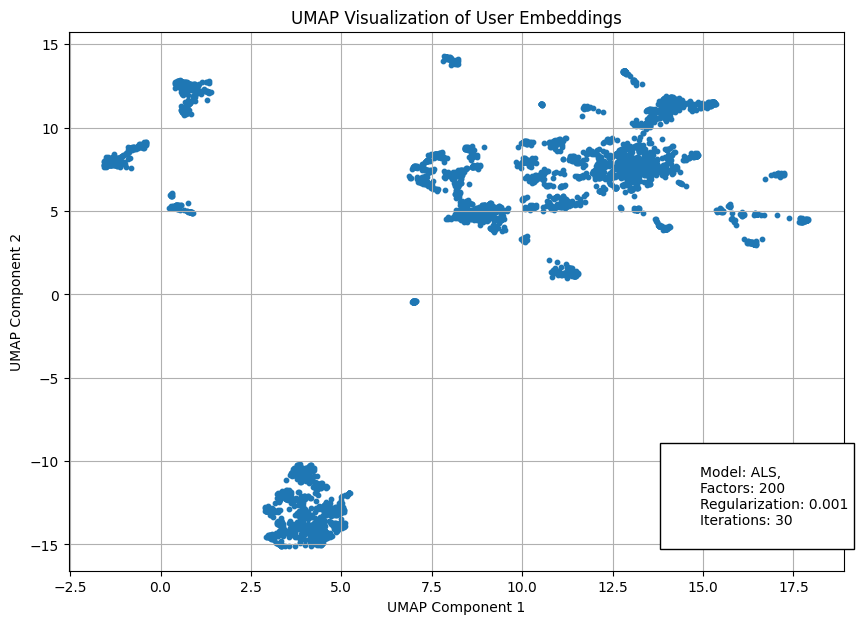

In [21]:
fals.figure_umap_embeddings(model, umap_embeddings_users, 'UMAP Visualization of User Embeddings')

## Clustering

#### KMeans

In [22]:
# kmeans_labels, kmeans_cosim_df, n_clusters = cl.print_kmeans(umap_embeddings_users, 29)
# kmeans_cosim_df

#### DBSCAN

[ True  True  True ...  True  True  True]
Estimated number of clusters: 29
Estimated number of noise points: 11
Silhouette Coefficient: 0.396


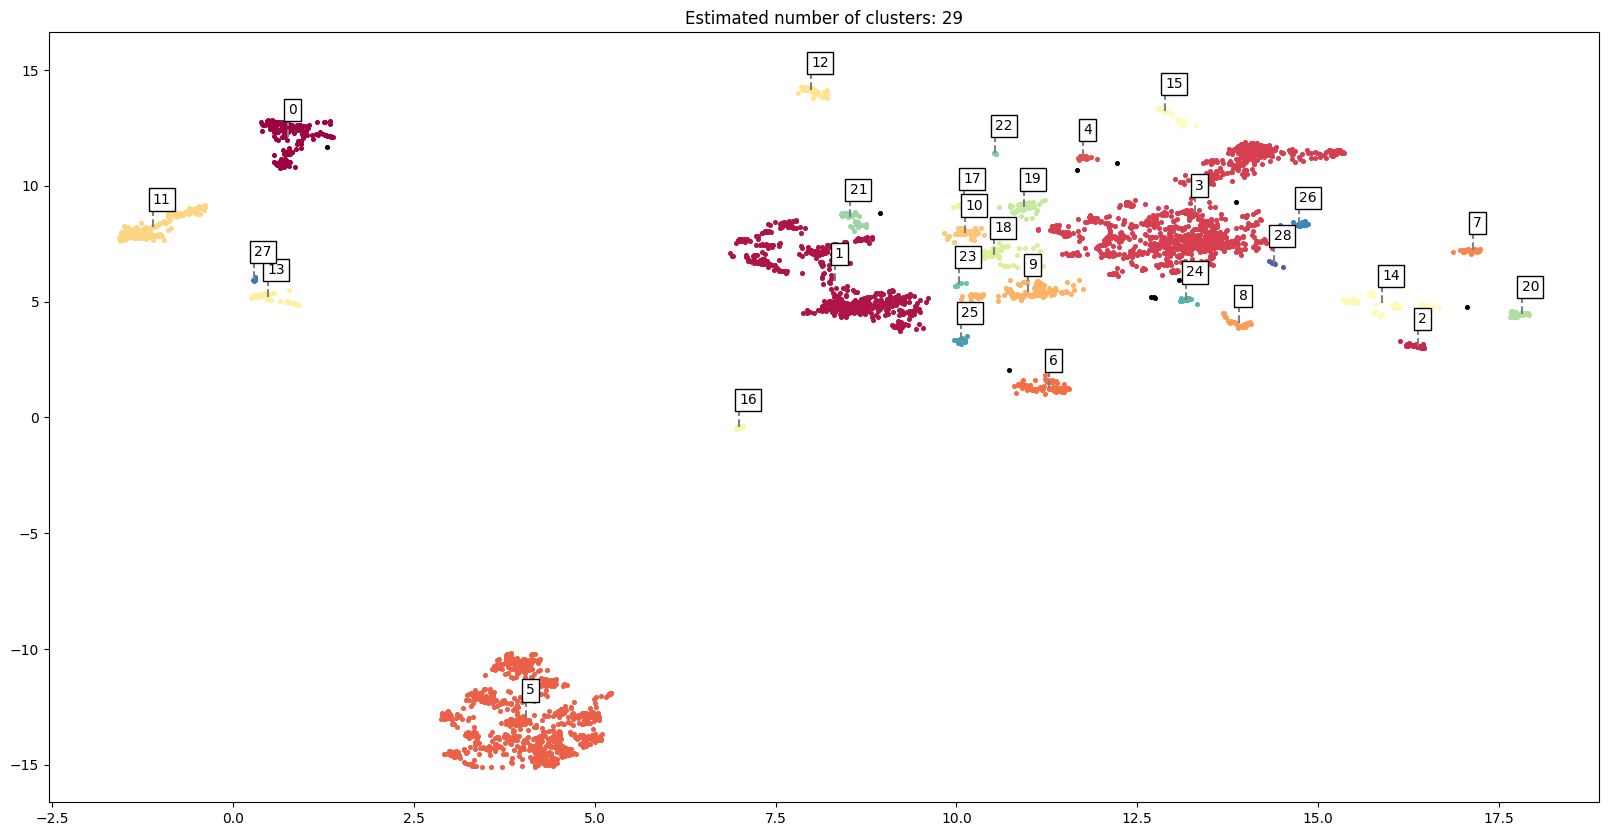

In [23]:
db_labels, db_cosim_df, n_clusters = cl.print_dbscan(umap_embeddings_users, 4)

In [24]:
db_cosim_df.head()

,Cluster #,Cosine Similarity
0,0,0.999714
1,1,0.981226
2,2,0.999982
3,3,0.994667
4,4,0.999978


In [25]:
train_df_with_clusters = cl.create_df_with_cl(umap_embeddings_users, db_labels, train_df)
# train_df_with_clusters.head(2)

In [26]:
userid = 'numeric_user_id'
itemid = 'numeric_trackable_name'
# pd.set_option('display.max_colwidth', None)

result = test_df.groupby(userid)[itemid].unique().reset_index()
result.columns=[userid, 'actual']
result.head(6)

count_trname_by_cluster = cl.create_count_trname_by_cluster_dict(n_clusters, train_df_with_clusters, result)

In [27]:
count_trname_by_cluster[12].head(10)

,numeric_trackable_name,count
0,17,3739
1,1167,393
2,18,347
3,21,342
4,124,341
5,26,339
6,55,337
7,122,313
8,238,298
9,226,249


In [28]:
clusters = cl.create_usual_features_in_clusters(count_trname_by_cluster, threshold_by_item=0.1, threshold_by_main_group=0.5)

In [ ]:
# clusters
# mapping_matrix_trackable.head(12)

In [29]:
# create clusters with sting dis
pd.set_option('display.max_colwidth', None)

def create_clusters_disease():
    clusters_dis={}
    mapping_dict = map_new.set_index('numeric_trackable_name')['trackable_name'].to_dict()
    for cluster_id, numeric_trackable_names in clusters.items():
        clusters_dis[cluster_id] = [mapping_dict.get(numeric_trackable_name, numeric_trackable_name) for numeric_trackable_name in numeric_trackable_names]

    df_clusters = pd.DataFrame(clusters_dis.items(), columns=['cluster_id', 'disease_ids'])
    df_clusters.set_index('cluster_id', inplace=True)
    return df_clusters

df_clusters = create_clusters_disease()
df_clusters

,disease_ids
cluster_id,
0,[chronic fatigue syndrome]
1,"[depression, anxiety]"
2,[rheumatoid arthritis]
3,"[unknown lower limb neurology condition, migraine, fatigue, asthma, ibs, headaches, chronic migraines, joint pain, depression, irritable bowel syndrome, arthritis, allergies, neck pain, lower back pain, chest pain, chronic daily headaches]"
4,[ulcerative colitis]
5,[fibromyalgia]
6,[endometriosis]
7,[crohns disease]
8,[psoriatic arthritis]


# Model Prediction

In [30]:
TEST_USER_ID = 999
# 30 - norm
# 1348 - одни и те же заболевания
# 999 - 1 старое не вошло

def reccomendation(model, n,  userid, user_item_matrix, userid_to_id):
    recs = model.recommend(userid=userid_to_id[userid],  
                        user_items=csr_matrix(user_item_matrix.loc[userid_to_id[TEST_USER_ID]]).tocsr(),  
                        N=n, 
                        recalculate_user=True,
                        filter_already_liked_items=False)
    return recs[0]

recs = reccomendation(model_als, 10, TEST_USER_ID, user_item_matrix, userid_to_id)

# recs = model_als.recommend(userid=userid_to_id[TEST_USER_ID],  
#                         user_items=csr_matrix(user_item_matrix.loc[userid_to_id[TEST_USER_ID]]).tocsr(),  
#                         N=10, 
#                         recalculate_user=True,
#                         filter_already_liked_items=False)

recs

array([210,   8,  54,  15,  31, 158,  17, 168, 177,  12], dtype=int32)

In [31]:
cluster = user_df(train_df_with_clusters,TEST_USER_ID)["cluster_id"].unique()[0]
opisanie = df_clusters.loc[cluster].iloc[0] 
print("Cluster =", cluster, ":", opisanie)

Cluster = 5.0 : ['fibromyalgia']


In [32]:
user_df_train = user_df(train_df,TEST_USER_ID)
user_df_test = user_df(test_df,TEST_USER_ID)

def sort_df_by_sum_value(df):
    df[['numeric_trackable_name','trackable_value']]
    df = df.groupby('numeric_trackable_name')['trackable_value'].sum().reset_index()
    df = df.sort_values(by='trackable_value', ascending=False)
    return df

value_user_train = sort_df_by_sum_value(user_df_train)
value_user_test = sort_df_by_sum_value(user_df_test)

diff_train_test_data = pd.merge(value_user_train,value_user_test, how='outer', on='numeric_trackable_name')
diff_train_test_data = diff_train_test_data.rename(columns={'trackable_value_x': 'weight_all','trackable_value_y':'weight_last'})
diff_train_test_data = pd.merge(diff_train_test_data,mapping_matrix_trackable, how='left', on='numeric_trackable_name')
diff_train_test_data = diff_train_test_data.iloc[:, [0,3,1,2]]

diff_train_test_data

,numeric_trackable_name,trackable_name,weight_all,weight_last
0,192,scoliosis,80,4.0
1,243,postural orthostatic tachycardia syndrome,57,4.0
2,9,depression,50,3.0
3,203,social anxiety disorder,42,2.0
4,519,heds,39,3.0
5,16,chronic migraines,36,1.0
6,58,generalized anxiety disorder,36,3.0
7,32,anxiety,35,2.0
8,18,fibromyalgia,28,1.0
9,13,cptsd,20,2.0


In [ ]:
# map_new['index'] - верная матрица теперь для рекомендаций
# mapping_matrix_trackable["numeric_trackable_name"] - верная матрица для старых значений

In [33]:
recomendations = pd.DataFrame({'index': recs})
recomendations = recomendations.merge(map_new, on='index', how='left')
recomendations = recomendations.drop(columns='index')

recomendations.numeric_trackable_name.to_list()

[243, 9, 58, 16, 32, 181, 18, 192, 203, 13]

In [34]:
test_dfd = test_df.drop(columns=["age", "sex", "country","checkin_date"])

# Calculation recs for test users

In [35]:
k=10
test_users = test_dfd["numeric_user_id"].unique()

In [36]:

def trackable_name_list_by_user(df, user):
    return df[df["numeric_user_id"]==user].numeric_trackable_name.to_list()

def calculate_recommendations_for_user(userid, model, k, user_item_matrix=user_item_matrix, userid_to_id=userid_to_id, map_new=map_new):
    
    def recommendations_list_by_user(recs,map_new):
        recomendations = pd.DataFrame({'index': recs})
        recomendations = recomendations.merge(map_new, on='index', how='left')
        recomendations = recomendations.drop(columns='index')
        return recomendations.numeric_trackable_name.to_list()

    def reccomendation(model, n,  userid, user_item_matrix, userid_to_id):
        recs = model.recommend(userid=userid_to_id[userid],  
                            user_items=csr_matrix(user_item_matrix.loc[userid_to_id[userid]]).tocsr(),  
                            N=n, 
                            recalculate_user=True,
                            filter_already_liked_items=False)
        return recs[0]
    
    recs = reccomendation(model, k, userid, user_item_matrix, userid_to_id)
    recommend_value_list = recommendations_list_by_user(recs, map_new)

    return recommend_value_list

In [37]:
df_for_metrics = pd.DataFrame(columns=['user_id', 'actual','recommendations'])

for userid in test_users:
    df_for_metrics=pd.concat([pd.DataFrame([
            {   
                'user_id': userid, 
                'actual': trackable_name_list_by_user(test_dfd, userid), 
                'recommendations': calculate_recommendations_for_user(userid, model_als, k)
             }]),
            df_for_metrics],ignore_index=True)

In [ ]:
df_for_metrics.set_index('user_id', inplace=True)

In [52]:
df_for_metrics.sort_index().head(20)

,actual,recommendations
user_id,,
0,[95],"[9, 38, 32, 160, 0, 61, 179, 180, 95, 667]"
1,"[8, 25, 271]","[8, 25, 271, 0, 948, 412, 947, 1146, 826, 775]"
2,"[15, 136, 195]","[9, 195, 24, 136, 79, 282, 281, 15, 283, 372]"
3,"[21, 109, 313]","[109, 0, 313, 51, 21, 53, 356, 142, 445, 978]"
4,[0],"[11, 132, 118, 61, 97, 999999, 388, 121, 147, 193]"
5,[0],"[0, 142, 445, 313, 542, 913, 180, 482, 556, 388]"
6,[0],"[0, 142, 445, 313, 542, 913, 180, 482, 556, 388]"
7,[0],"[0, 142, 445, 313, 542, 913, 180, 482, 556, 388]"
8,"[0, 188, 352]","[188, 538, 612, 157, 227, 518, 126, 566, 73, 533]"


In [49]:
df_for_metrics.sort_index().to_csv('test.csv', encoding='utf-8')